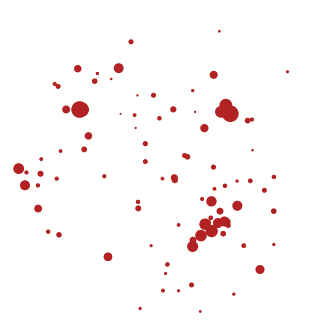

In [1]:
#           _   _ _____ __  __       _______ _____ ____  _   _ 
#     /\   | \ | |_   _|  \/  |   /\|__   __|_   _/ __ \| \ | |
#    /  \  |  \| | | | | \  / |  /  \  | |    | || |  | |  \| |
#   / /\ \ | . ` | | | | |\/| | / /\ \ | |    | || |  | | . ` |
#  / ____ \| |\  |_| |_| |  | |/ ____ \| |   _| || |__| | |\  |
# /_/    \_\_| \_|_____|_|  |_/_/    \_\_|  |_____\____/|_| \_|
#  ________   __          __  __ _____  _      ______
# |  ____\ \ / /    /\   |  \/  |  __ \| |    |  ____|
# | |__   \ V /    /  \  | \  / | |__) | |    | |__
# |  __|   > <    / /\ \ | |\/| |  ___/| |    |  __|
# | |____ / . \  / ____ \| |  | | |    | |____| |____
# |______/_/ \_\/_/    \_\_|  |_|_|    |______|______|

# EnergyFlow - Python package for high-energy particle physics.
# Copyright (C) 2017-2020 Patrick T. Komiske III and Eric Metodiev

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# matplotlib is required for this example
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4,4)

#############################################################
# NOTE: ffmpeg must be installed
# on macOS this can be done with `brew install ffmpeg`
# on Ubuntu this would be `sudo apt-get install ffmpeg`
#############################################################

# on windows, the following might need to be uncommented
#plt.rcParams['animation.ffmpeg_path'] = 'C:\\ffmpeg\\bin\\ffmpeg.exe'

import energyflow as ef
from matplotlib import animation, rc

# helper function to interpolate between the optimal transport of two events
def merge(ev0, ev1, R=1, lamb=0.5):    
    emd, G = ef.emd.emd(ev0, ev1, R=R, return_flow=True)

    merged = []
    for i in range(len(ev0)):
        for j in range(len(ev1)):
            if G[i, j] > 0:
                merged.append([G[i,j], lamb*ev0[i,1] + (1-lamb)*ev1[j,1], 
                                       lamb*ev0[i,2] + (1-lamb)*ev1[j,2]])

    # detect which event has more pT
    if np.sum(ev0[:,0]) > np.sum(ev1[:,0]):
        for i in range(len(ev0)):
            if G[i,-1] > 0:
                merged.append([G[i,-1]*lamb, ev0[i,1], ev0[i,2]])
    else:
        for j in range(len(ev1)):
            if G[-1,j] > 0:
                merged.append([G[-1,j]*(1-lamb), ev1[j,1], ev1[j,2]])            

    return np.asarray(merged)


#############################################################
# ANIMATION OPTIONS
#############################################################
zf = 9           # size of points in scatter plot
lw = 1           # linewidth of flow lines
fps = 25         # frames per second, increase this for sharper resolution
nframes = 100 # total number of frames
R = 0.5          # jet radius


#############################################################
# LOAD IN JETS
#############################################################
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']
events = ef.mod.load(*specs, dataset='cms', amount=0.01)

# events go here as lists of particle [pT,y,phi]
event0 = events.particles[14930][:,:3]
event1 = events.particles[19751][:,:3]

# center the jets
event0[:,1:3] -= np.average(event0[:,1:3], weights=event0[:,0], axis=0)
event1[:,1:3] -= np.average(event1[:,1:3], weights=event1[:,0], axis=0)

# mask out particles outside of the cone
event0 = event0[np.linalg.norm(event0[:,1:3], axis=1) < R]
event1 = event1[np.linalg.norm(event1[:,1:3], axis=1) < R]

ev0 = np.copy(event0)
ev1 = np.copy(event1)

#############################################################
# MAKE ANIMATION
#############################################################

fig, ax = plt.subplots()

merged = merge(ev0, ev1, lamb=0, R=R)
pts, ys, phis = merged[:,0], merged[:,1], merged[:,2]

scatter = ax.scatter(ys, phis, color='blue', s=pts, lw=0)

# animation function. This is called sequentially
def animate(i):
    ax.clear()

    # Define the number of transition phases
    nstages = 2

    # Transition from event0 to event1
    if i < nframes / nstages:
        lamb = nstages * i / (nframes - 1)
        ev0 = event0
        ev1 = event1
        color = "firebrick"  # (1 - lamb) * np.asarray([1, 0, 0]) + (lamb) * np.asarray([0, 0, 1])

    # Transition from event1 to event0
    else:
        lamb = nstages * (i - nframes / nstages) / (nframes - 1)
        ev0 = event1
        ev1 = event0
        color = "firebrick"  #  (lamb) * np.asarray([1, 0, 0]) + (1 - lamb) * np.asarray([0, 0, 1])

    merged = merge(ev0, ev1, lamb=lamb, R=0.5)
    pts, ys, phis = merged[:, 0], merged[:, 1], merged[:, 2]
    scatter = ax.scatter(ys, phis, color=color, s=zf * pts, lw=0)

    ax.set_xlim(-R, R)
    ax.set_ylim(-R, R)
    ax.set_axis_off()

    return scatter,

anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=True)
anim.save('../static/energyflowanimation.gif', fps=fps, dpi=200)